In [2]:
"""
Run regressions that strip predictable components of consumption and income
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('/home/mitch/school/data/mexico_enigh/src/')

import utils
import os

import statsmodels.stats.weightstats as ws

plotdir = '/home/mitch/school/data/mexico_enigh/fig/'
processed = '/home/mitch/Dropbox/data/mexico_enigh/processed/'

save = False


In [3]:
os.chdir(processed)
df = pd.read_csv('data.csv')

/tmp/ipykernel_301664/678744357.py:2: DtypeWarning: Columns (92,101,254,305,306,314,319,324) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


In [4]:
cpidir = '/home/mitch/Dropbox/data/cpi/'
os.chdir(cpidir)
cpi = pd.read_csv('cpi_annual.csv')
cpi = cpi.rename(columns = {'time':'Y', 'PCPI_IX':'cpi'})
cpi = cpi.query('country == "MX"')
cpi = cpi.drop(columns=['Unnamed: 0', 'country'])

In [5]:
cpi

,Y,cpi
73,1950,0.006298
74,1951,0.007090
75,1952,0.008101
76,1953,0.007978
77,1954,0.008365
...,...,...
141,2018,136.576649
142,2019,141.542523
143,2020,146.350488
144,2021,154.676672


In [6]:
df = df.merge(cpi, on='Y', how='inner')

In [7]:
df.Y.value_counts().sort_index()

Y
1992    10530
1994    12815
1996    14042
1998    10952
2000    10108
2002    17167
2004    22595
2006    20875
2008    30808
Name: count, dtype: int64

In [8]:
# don't include: other income
# transfers
# rental income

# do include:
# salary income
# business income

is1992 = df['Y'] == 1992

#income = ['income_salary', 'income_business', 'income_transfers']
income = ['income_salary', 'income_business', 'income_transfers']
#income = ['income_salary', 'income_business']
df['income'] = df[income].sum(axis=1)
df['income'] = df['income'] / df['cpi']
df['income'] = df['income'] / df['hh_size']
df.loc[is1992, 'income'] = df.loc[is1992, 'income'] / 1000
df['log_income'] = np.log(df['income'])

#consumption = ['consumption_food', 'consumption_clothing', 'consumption_personal']
#consumption = ['consumption_food', 'consumption_clothing', 'consumption_transportation']
consumption = ['gasnom']
df['consumption'] = df[consumption].sum(axis=1)
df['consumption'] = df['consumption'] / df['cpi']
df['consumption'] = df['consumption'] / df['hh_size']
df.loc[is1992, 'consumption'] = df.loc[is1992, 'consumption'] / 1000
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
df = df.query('income > 0')
df = df.query('consumption > 0')
df = df.query('age >= 25')
df = df.query('age <= 65')
df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]; print(len(df))
df.Y.value_counts().sort_index()


82042


Y
1992     4866
1994     6001
1996     7527
1998     5467
2000     5294
2002     9869
2004    13316
2006    11728
2008    17974
Name: count, dtype: int64

In [10]:
consumption_to_income = ws.DescrStatsW(df['consumption'] / df['income'], weights=df['weight'])
consumption_to_income_005 = consumption_to_income.quantile(0.005)
consumption_to_income_995 = consumption_to_income.quantile(0.995)
df = df[df['consumption'] / df['income'] > consumption_to_income_005.values[0]]
df = df[df['consumption'] / df['income'] < consumption_to_income_995.values[0]]


In [15]:
import statsmodels.stats.weightstats as ws
byyear = {}
for year in df.Y.unique():
    focus = df.query('Y == @year')
    byyear[year] = ws.DescrStatsW(focus['log_income'], weights=focus['weight']).mean
    

In [30]:
df.groupby('Y')['log_income'].mean()

Y
1992    4.022979
1994    4.063689
1996    3.758197
1998    3.936951
2000    4.068489
2002    4.054173
2004    4.204049
2006    4.234379
2008    4.165775
Name: log_income, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


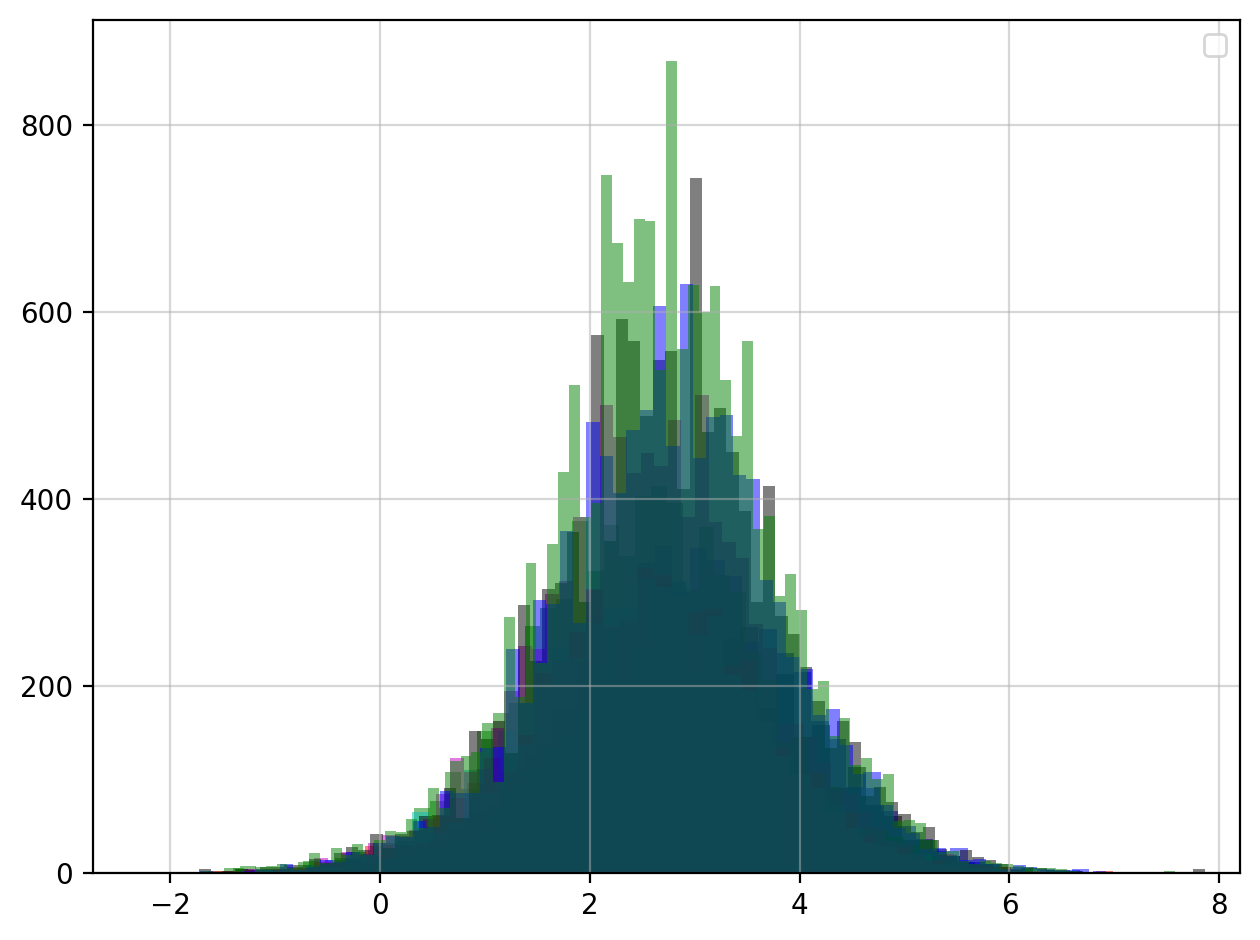

In [31]:
plt.clf()
for year in df['Y'].unique():
    plt.hist(df.query('Y == @year')['log_consumption'], alpha=0.5)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


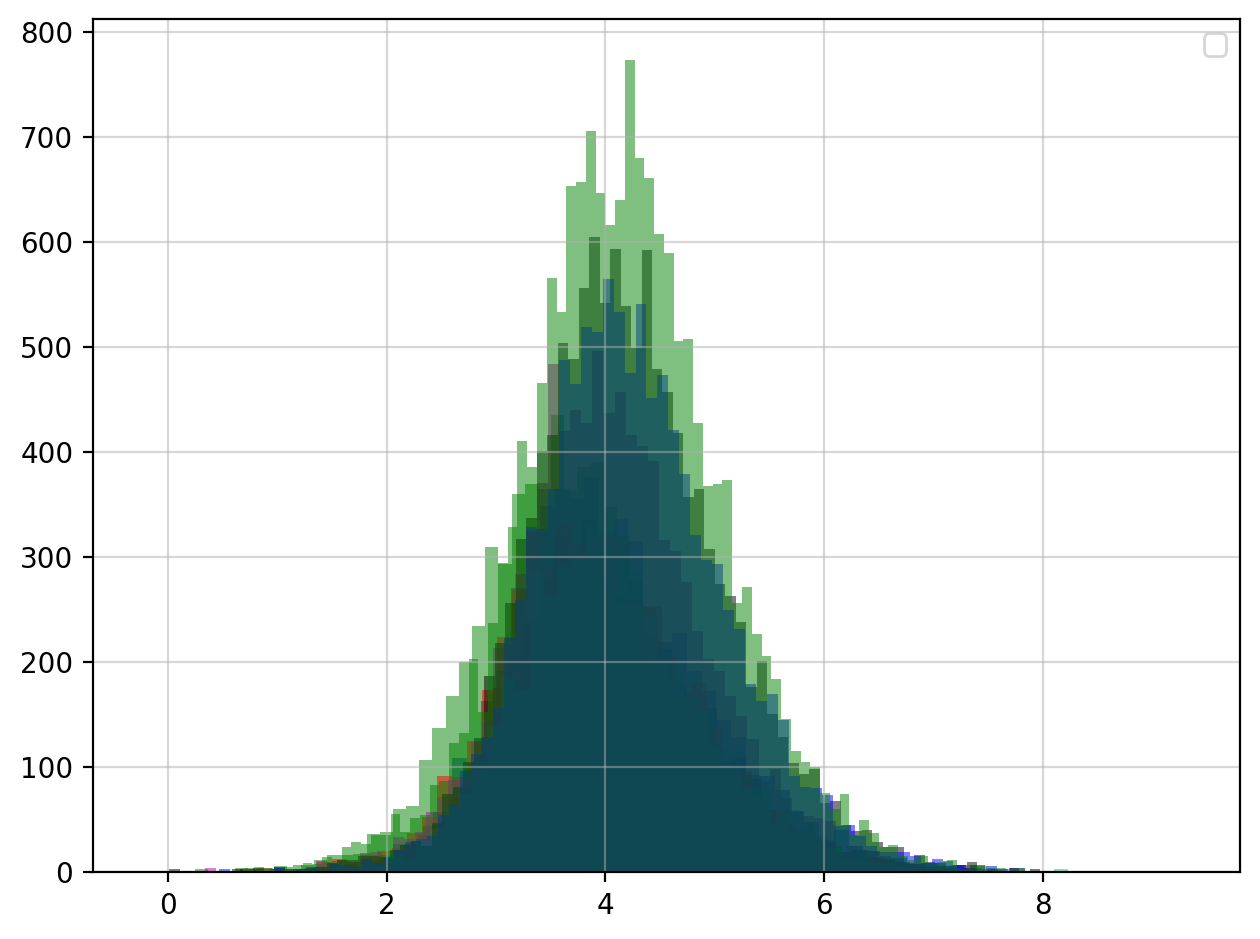

In [32]:
plt.clf()
for year in df['Y'].unique():
    plt.hist(df.query('Y == @year')['log_income'], alpha=0.5)
plt.legend()
plt.show()

In [33]:
df['log_income']      = utils.residualize_income(df)
df['income'] = df['log_income'].apply(np.exp)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             log_income   No. Observations:                75251
Model:                            GLM   Df Residuals:                116364045
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                         0.74527
Method:                          IRLS   Log-Likelihood:            -1.4801e+08
Date:                Thu, 16 Nov 2023   Deviance:                   8.6722e+07
Time:                        14:07:27   Pearson chi2:                 8.67e+07
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -24.29

In [34]:
df['log_consumption'] = utils.residualize_consumption(df)
df['consumption'] = df['log_consumption'].apply(np.exp)

                 Generalized Linear Model Regression Results                  
Dep. Variable:        log_consumption   No. Observations:                75251
Model:                            GLM   Df Residuals:                116364045
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          1.1428
Method:                          IRLS   Log-Likelihood:            -1.7288e+08
Date:                Thu, 16 Nov 2023   Deviance:                   1.3298e+08
Time:                        14:07:27   Pearson chi2:                 1.33e+08
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                25.36

In [36]:
years = np.sort(df.Y.unique())

income_by_decile = pd.DataFrame(columns=years, index=np.arange(1, 11))
consumption_by_decile = pd.DataFrame(columns=years, index=np.arange(1, 11))

for year in years:
        income      = utils.indicator_by_decile(df.query('Y == @year'), 'income', 'log_income', 'weight')
        consumption = utils.indicator_by_decile(df.query('Y == @year'), 'income', 'log_consumption', 'weight')

        income_by_decile[year]      = income
        consumption_by_decile[year] = consumption

income_by_decile

def elasticity(y1, y2, income_by_decile=income_by_decile, consumption_by_decile=consumption_by_decile):
        e = (consumption_by_decile[y2] - consumption_by_decile[y1]) / (income_by_decile[y2] - income_by_decile[y1])
        return e

In [37]:
income_by_decile

,1992,1994,1996,1998,2000,2002,2004,2006,2008
1,-1.268834,-1.243027,-1.601851,-1.554815,-1.26445,-1.338963,-1.335059,-1.232497,-1.5275
2,-0.757407,-0.749778,-1.07422,-0.967812,-0.816355,-0.806299,-0.800958,-0.728573,-0.883513
3,-0.492558,-0.487643,-0.815535,-0.691454,-0.549051,-0.559541,-0.546616,-0.474277,-0.604404
4,-0.288153,-0.280106,-0.591275,-0.486331,-0.337654,-0.349536,-0.334121,-0.272252,-0.380236
5,-0.083223,-0.07375,-0.381472,-0.281631,-0.149717,-0.165219,-0.145768,-0.083325,-0.17926
6,0.117141,0.14832,-0.170686,-0.076359,0.03301,0.031242,0.060477,0.109654,0.025181
7,0.339148,0.386857,0.045565,0.158708,0.261761,0.237977,0.267467,0.319714,0.24388
8,0.62075,0.669238,0.316688,0.435944,0.559344,0.523241,0.525818,0.579126,0.491506
9,0.994973,1.063083,0.690251,0.783105,0.918907,0.902497,0.879603,0.928119,0.825877
10,1.769019,1.858795,1.446601,1.545225,1.746432,1.677234,1.59131,1.66322,1.550307


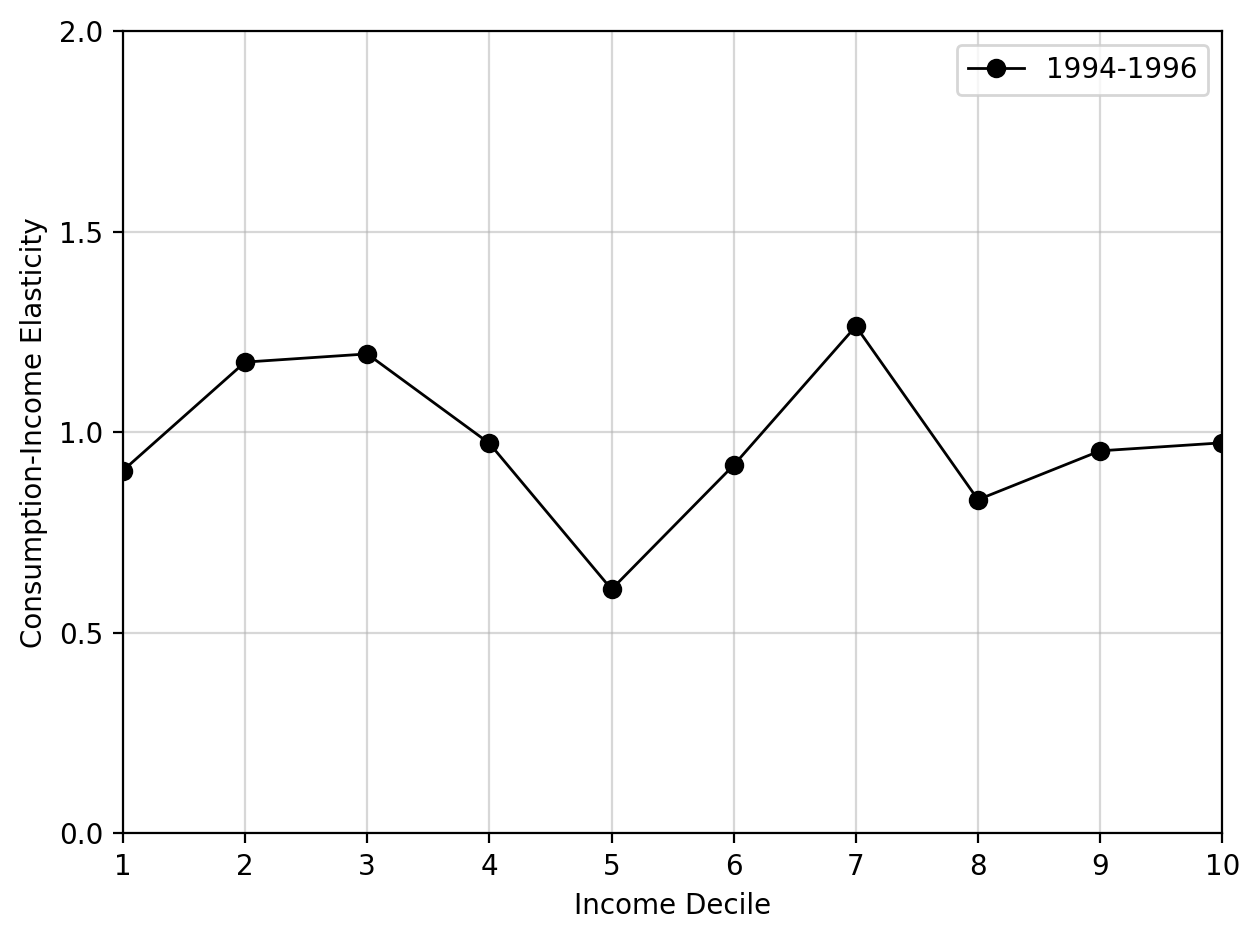

In [38]:

deciles = np.arange(1, 11)

os.chdir(plotdir)
plt.close()
plt.clf()
plt.plot(deciles, elasticity(1994, 1996), marker='o', label='1994-1996', linewidth=1)
plt.ylim(0.5, 1.5)
plt.yticks(np.arange(0.0, 2.5, 0.5))
plt.legend()
plt.xlabel('Income Decile')
plt.ylabel('Consumption-Income Elasticity')

os.chdir(plotdir)
#if save:
    #plt.savefig('consumption_income_elasticities_1994_1996.png')
plt.show()


In [39]:
elasticity(1994, 1996).mean()

0.9796062212258496

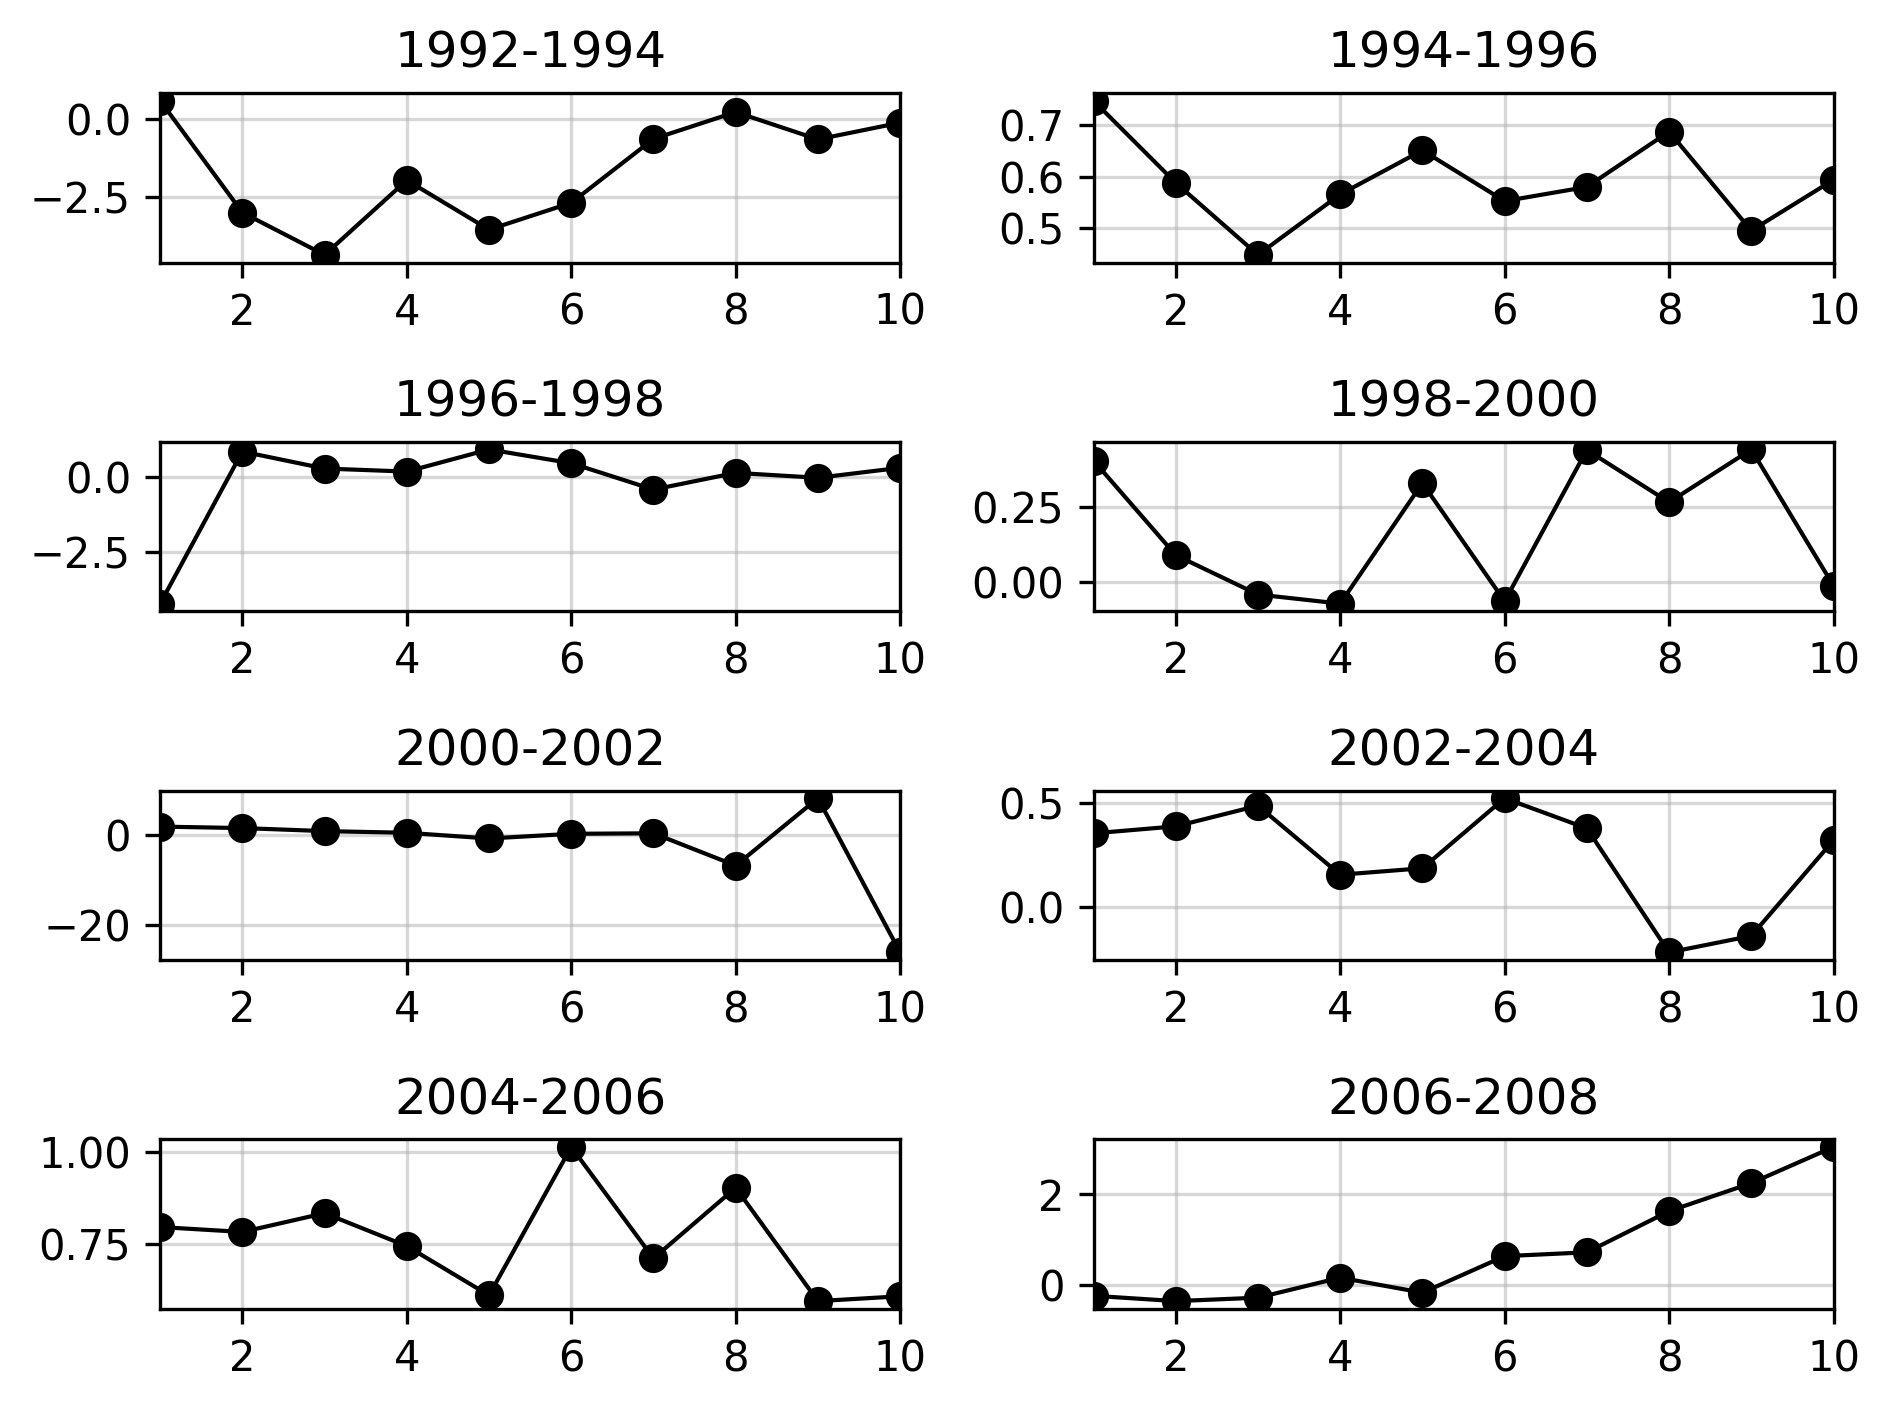

In [20]:
deciles = np.arange(1, 11)

os.chdir(plotdir)
plt.close()
plt.clf()
plt.subplot(421)
plt.plot(deciles, elasticity(1992, 1994), marker='o', label='1992-1994', linewidth=1)
plt.title('1992-1994')

plt.subplot(422)
plt.plot(deciles, elasticity(1994, 1996), marker='o', label='1994-1996', linewidth=1)
plt.title('1994-1996')

plt.subplot(423)
plt.plot(deciles, elasticity(1996, 1998), marker='o', label='1996-1998', linewidth=1)
plt.title('1996-1998')

plt.subplot(424)
plt.plot(deciles, elasticity(1998, 2000), marker='o', label='1998-2000', linewidth=1)
plt.title('1998-2000')

plt.subplot(425)
plt.plot(deciles, elasticity(2000, 2002), marker='o', label='2000-2002', linewidth=1)
plt.title('2000-2002')

plt.subplot(426)
plt.plot(deciles, elasticity(2002, 2004), marker='o', label='2002-2004', linewidth=1)
plt.title('2002-2004')

plt.subplot(427)
plt.plot(deciles, elasticity(2004, 2006), marker='o', label='2002-2004', linewidth=1)
plt.title('2004-2006')

plt.subplot(428)
plt.plot(deciles, elasticity(2006, 2008), marker='o', label='2002-2004', linewidth=1)
plt.title('2006-2008')

#plt.ylim(0.5, 1.5)
#plt.yticks(np.arange(0.0, 2.5, 0.5))

os.chdir(plotdir)
if save:
    plt.savefig('consumption_income_elasticities.png')
plt.show()


In [18]:
years = np.sort(df.Y.unique())

income_by_decile = pd.DataFrame(columns=years, index=np.arange(1, 11))
consumption_by_decile = pd.DataFrame(columns=years, index=np.arange(1, 11))

for year in years:
        income      = utils.indicator_by_decile(df.query('Y == @year'), 'income', 'income', 'weight')
        consumption = utils.indicator_by_decile(df.query('Y == @year'), 'income', 'consumption', 'weight')

        income_by_decile[year]      = income
        consumption_by_decile[year] = consumption

consumption_by_decile = consumption_by_decile.astype('float')
income_by_decile = income_by_decile.astype('float')

def alt_elasticity(y1, y2, income_by_decile=income_by_decile, consumption_by_decile=consumption_by_decile):
        e = (np.log(consumption_by_decile[y2]) - np.log(consumption_by_decile[y1])) / (np.log(income_by_decile[y2]) - np.log(income_by_decile[y1]))
        return e

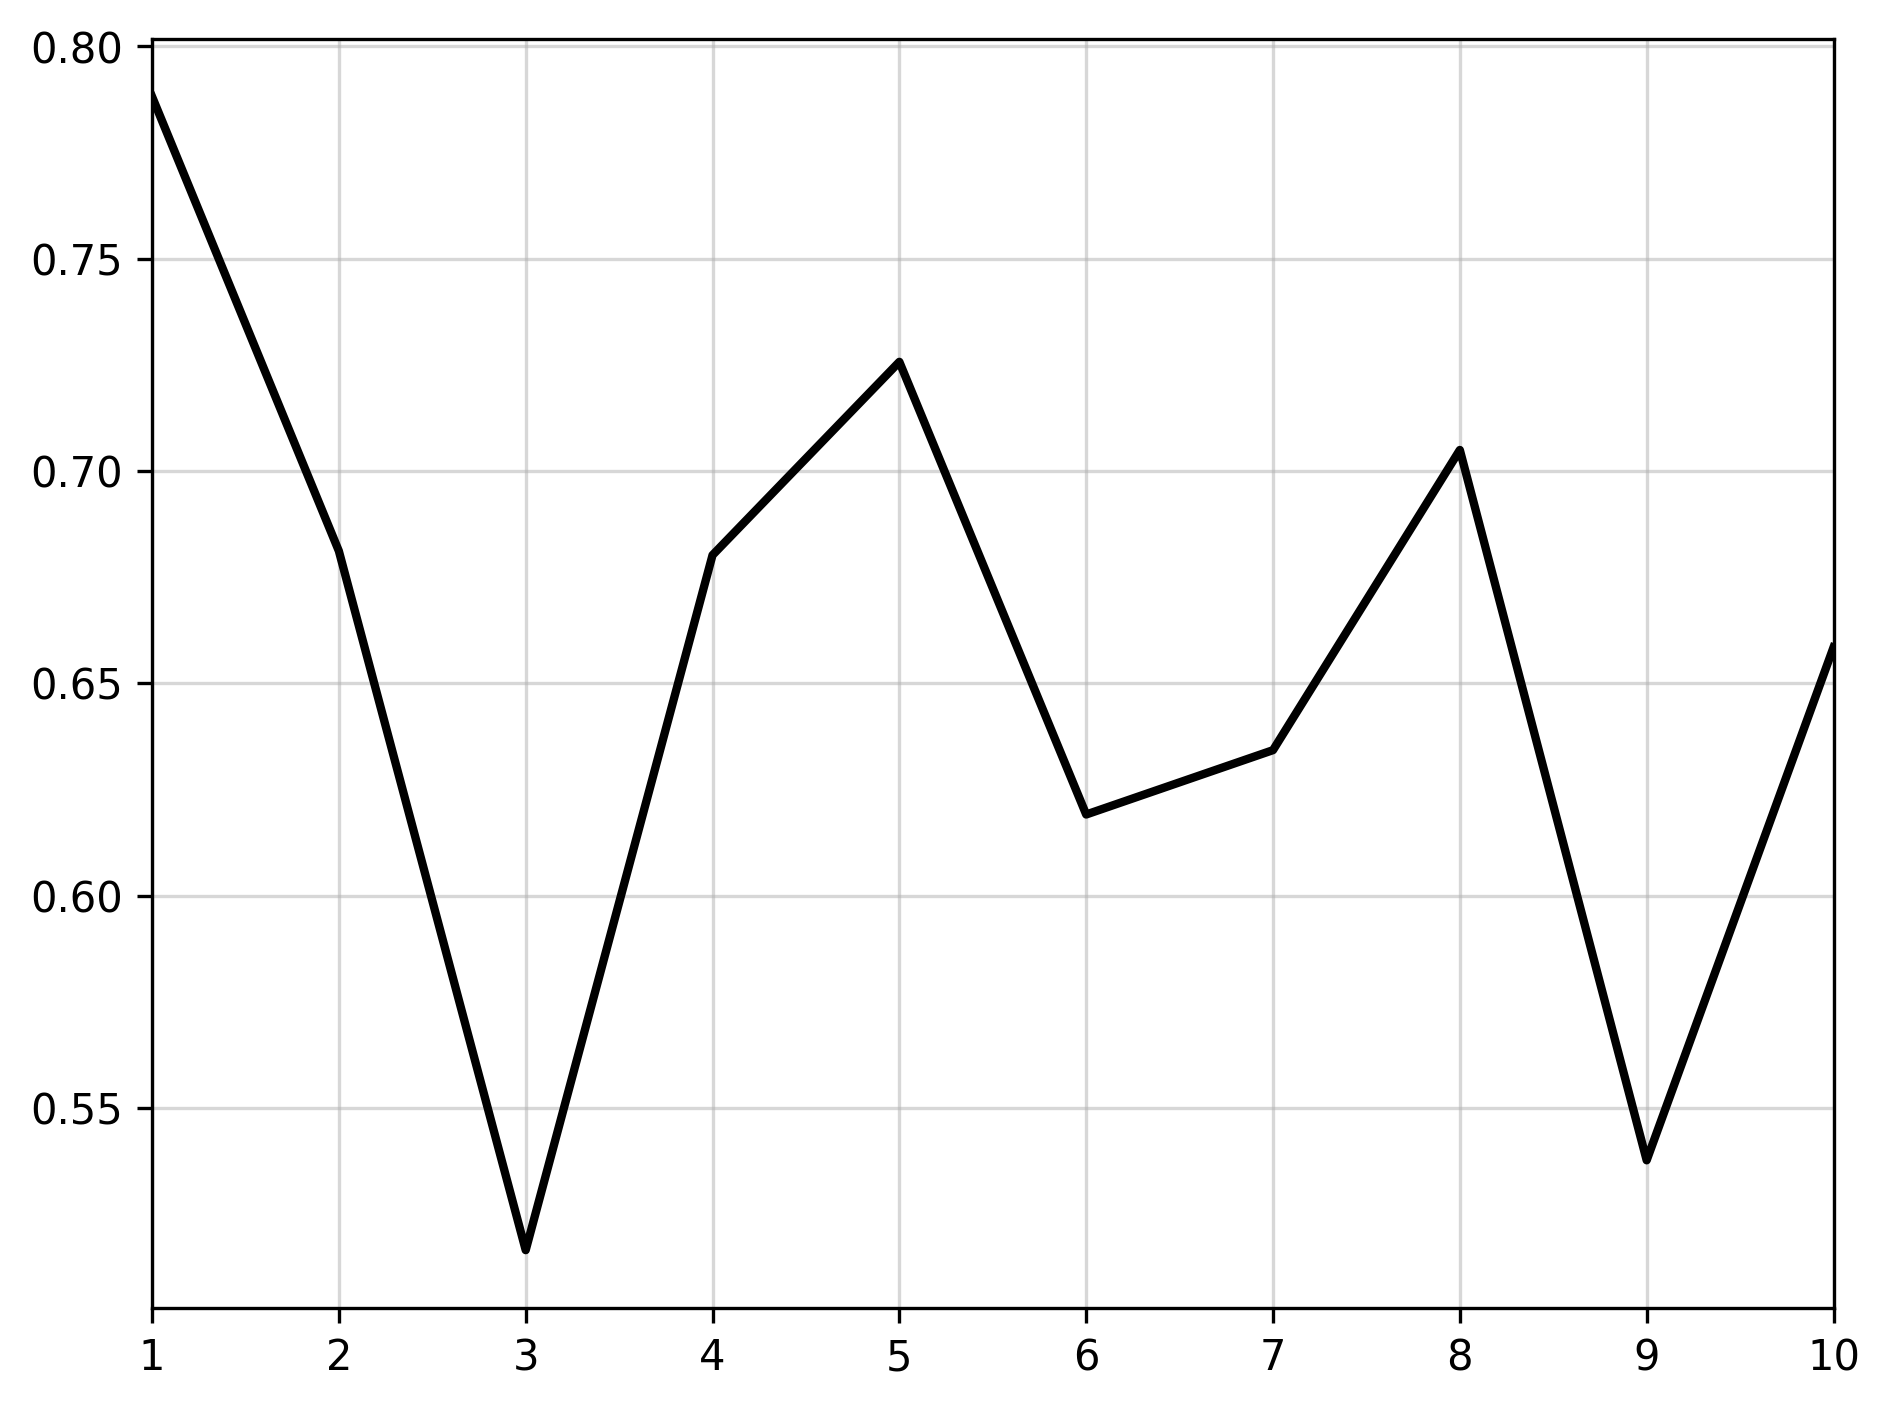

In [19]:
plt.clf()
plt.plot(alt_elasticity(1994, 1996))
plt.show()

In [ ]:
df.groupby('Y')['log_income'].mean()

Y
1992    0.120946
1994    0.124694
1996   -0.168852
1998   -0.083706
2000    0.014131
2002   -0.013548
2004   -0.100761
2006    0.085212
2008    0.024653
Name: log_income, dtype: float64

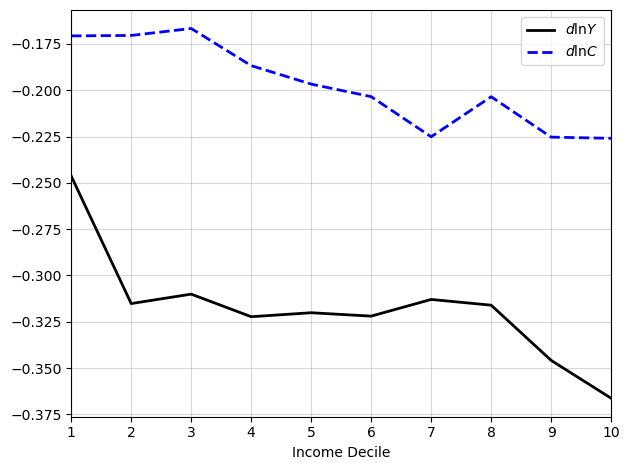

In [ ]:
plt.clf()
plt.plot(deciles, income_by_decile[1996] - income_by_decile[1994], label = r'$d \ln Y$')
plt.plot(deciles, consumption_by_decile[1996] - consumption_by_decile[1994], label = r'$d \ln C$')
plt.xlabel('Income Decile')
plt.legend()
plt.show()

In [ ]:
# note: using entidad does bring some sanity
# what I need to fix is: the long run increases in income and consumption
# honestly wouldn't hurt to just use the aggregate data